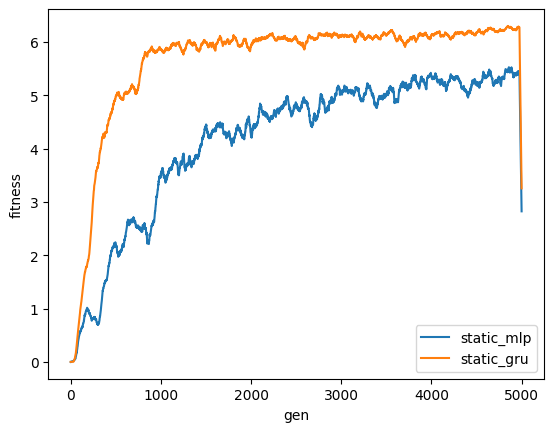

In [4]:
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import numpy as np
import os

trials = 10
stat_run_base_path = "/home/magraz/rovers/pyrover_domain/experiments/results/completed/"
experiment_type = "fitness_critic"
configurations = ["static_mlp", "static_gru"]
stat_run_paths = [os.path.join(stat_run_base_path, "_".join((experiment_type, config))) for config in configurations]


def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, "same")


dd_list = []
for i in range(len(stat_run_paths)):

    for trial in range(trials):

        dd = defaultdict(list)

        with open(
            os.path.join(stat_run_paths[i], "_".join(("trial", str(trial), configurations[i])), "fitness.csv"), "r"
        ) as csvfile:
            for line in csv.DictReader(csvfile):
                for key, value in line.items():
                    if key != "" and value != "" and value != None and not isinstance(value, list):
                        dd[key].append(float(value))

        dd_list.append(dd)

avg_vals = []


for i in range(len(configurations)):
    config_vals = []
    for dd in dd_list[i * trials : (i + 1) * trials]:
        config_vals.append(dd["team_fitness"])

    avg_vals.append(np.sum(config_vals, axis=0)/trials)


fig = plt.figure()
ax = fig.add_subplot(111)

for vals in avg_vals:
    ax.plot(movingaverage(vals, 50))

ax.set_xlabel("gen")
ax.set_ylabel("fitness")

plt.legend(configurations) 

plt.show()
